In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

--2020-06-02 17:50:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 2607:f8b0:400c:c13::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.002s  

2020-06-02 17:50:29 (51.6 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [0]:
corpus=[]
with open('/tmp/sonnets.txt','r',encoding='utf-8') as shake:
  speare=shake.read().split('\n')
  for lines in speare:
    corpus.append(lines)

In [0]:
len(corpus)

2159

In [0]:
corpus[:5]

['FROM fairest creatures we desire increase,',
 "That thereby beauty's rose might never die,",
 'But as the riper should by time decease,',
 'His tender heir might bear his memory:',
 'But thou, contracted to thine own bright eyes,']

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [0]:
token=Tokenizer()
token.fit_on_texts(corpus)
word_index=token.word_index
vocab_size=len(word_index) + 1

In [0]:
vocab_size

3211

In [0]:
corpus_seq=token.texts_to_sequences(corpus)

In [0]:
corpus_seq[:2]

[[34, 417, 877, 166, 213, 517], [8, 878, 134, 351, 102, 156, 199]]

In [0]:
## incrementals
corpus_incremental=[]
for lines in corpus_seq:
  for i in range(2,len(lines) + 1):
    corpus_incremental.append(lines[:i])


In [0]:
corpus_incremental[:5]

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [0]:
max_length=0
for i in corpus_seq:
  if len(i)>max_length:
    max_length=len(i)


In [0]:
max_length

11

In [0]:
## Pad sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
corpus_pad_seq=pad_sequences(corpus_incremental,maxlen=max_length,padding='pre')

In [0]:
corpus_pad_seq[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213],
       [  0,   0,   0,   0,   0,  34, 417, 877, 166, 213, 517]],
      dtype=int32)

In [0]:
training_data=corpus_pad_seq[:,:-1]
training_label=corpus_pad_seq[:,-1]

In [0]:
training_data.shape,training_label.shape

((15462, 10), (15462, 3211))

In [0]:
from tensorflow.keras.utils import to_categorical
training_label=to_categorical(training_label,num_classes=vocab_size)

In [0]:
from tensorflow.keras.layers import Dense,LSTM,Embedding,Bidirectional,Dropout

In [0]:
model=keras.Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=100,input_length=max_length - 1))
model.add(Bidirectional(LSTM(150,return_sequences=True)))
model.add(Dropout(rate=0.2))
model.add(LSTM(100))
model.add(Dense(units=vocab_size/2,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(Dense(units=vocab_size,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_10 (Dense)             (None, 1605)              162105    
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [0]:
model.fit(training_data,training_label,epochs=100)

Epoch 1/100
484/484 [==============================] - 52s 108ms/step - loss: 6.9105 - accuracy: 0.0219
Epoch 2/100
444/484 [==========================>...] - ETA: 4s - loss: 6.4924 - accuracy: 0.0225

KeyboardInterrupt: ignored

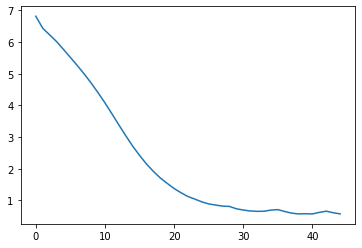

In [0]:
plt.plot(model.history.history['loss'])